# ADA Project
<br><br>

----
### Subject: 
finding what influence the number of protests among: area of the country, population density, net migration, infant mortality, deathrate, income group, climate, etc.  
<br><br>

----
### Objective: 
finding what to change in a country to decrease the number of protests (assuming that a less number of protests means that the inhabitants are happier)
<br><br>

----
### Summary:
First, we will get all the data we need. Second we will find a way to display data on a world map to visualize the number of protests around the world. Then, we will try to find the impact of many variables on this number of protests.
<br><br>

----
### Data explanations:
Please see the read me, section Dataset / 4- Data description to see data explanations

Here a brief explanation:

We are using the data available at the following link: https://bigquery.cloud.google.com/table/gdelt-bq:gdeltv2.events This is a context of **big data**: around **400 000 000** of rows.
<br><br>
- ##### <u>eventcodes.csv</u>

As we are interested in protest as kind of event, we need to find the event code associated to the protest events: **eventcodes.csv** gives us this data.
<br><br>
- ##### <u>country_by_income.csv and countries_stats.csv</u>

Then, we need to get data on all the countries to find the impact of their characteristics on the number of protests: **country_by_income.csv** and **countries_stats.csv** give us what we need. Thanks to these files, we have access to: the average income, area of the country, population density, net migration, infant mortality, deathrate, climate, etc of each country.
Got from: http://datatopics.worldbank.org/world-development-indicators/the-world-by-income-and-region.html and https://www.kaggle.com/fernandol/countries-of-the-world/version/1

<br><br>
Let's see the **countries_stats.csv** file:

data got from: https://www.kaggle.com/fernandol/countries-of-the-world/version/1

Data available: `Country`, `Region`, `Population`, `Area (sq. mi.)`, `Pop. Density (per sq. mi.)`, `Coastline (coast/area ratio)`, `Net migration`, `Infant mortality (per 1000 births)`, `GDP ($ per capita)`, `Literacy (%)`, `Phones (per 1000)`, `Arable (%)`, `Crops (%)`, `Other (%)`, `Climate`, `Birthrate`, `Deathrate`, `Agriculture`, `Industry`, `Service`.

Most of the variables don't need to be explain as `population`, `Area (sq. mi.)`, `Infant mortality`, etc. As we wordered the meaning of `climate`, here the explanation we found:

Meaning of `climate`: 1= Dry tropical, 2= Wet tropical, 3= Temperate humid subtropical and temperate continental, 4= Dry hot summers and wet winters
<br><br>
- ##### <u>country_codes_iso2_to_iso3.csv and country_code_to_name.csv</u>

Each data define the country in a different way: code in `ISO2` or `ISO3` or with the `country name`. We need to convert each ones with the same convention. For example, to define the United-States of America, the csv files use "USA", "US" or "United-States of America". 
**country_codes_iso2_to_iso3.csv** and **country_code_to_name.csv** allow us to achieve these conversions.
there are from: https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv
<br><br>

- ##### <u>GDP growth world bank.csv and GINI per country worldbank.csv</u> (<a> https://data.worldbank.org </a>)
These two dataset are the estimations of the Gross Domestic Product (GDP) and the Index of Inequality (GINI) for each country , from 1960 to 2017. These datasets will be usefull economical and social indicator to understand the protestation in different countries.


- ##### <u>DataCorruptionPerceptionIndex2000_2017.xlsx</u> (<a>https://www.transparency.org</a>)
This data set shows the estimated Corruption index (political and buisness corruption) for each country from 2000 to 2017. 


- ##### <u>Human Development Index (HDI).csv</u> (<a> http://hdr.undp.org/en/data </a>)
Dataset of the HDI for each country from 1990 to 2017.
HDI a good indicator of the life expectancy and education of people in the country.
The definition of HDI from wikipedia:
"The Human Development Index (HDI) is a statistic composite index of life expectancy, education, and per capita income indicators"



- ##### <u>World press freedom.csv
</u> (<a> https://rsf.org/fr/donnees-classement </a>)(<a> https://en.wikipedia.org/wiki/Press_Freedom_Index </a>)

This data-set shows the score of each country concerning the press freedom from 2002 to 2018



----
### Next steps until Dec. 16
Please see the read me, section "A list of internal milestones until Dec. 16" or the end of the notebook as asked here: https://dlab.epfl.ch/teaching/fall2018/cs401/projects/

In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import os
import json
import folium
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from sklearn.linear_model import LinearRegression, LogisticRegression
from branca.colormap import linear
import statsmodels.api as sm
from scipy import stats


DATA_PATH = "data/"

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'C:\\Users\\bronner\\Downloads\\ADATTC-fb24a0224f16.json'
# get json by following (Setting up authentication)
# https://cloud.google.com/bigquery/docs/reference/libraries

In [2]:
bigquery_client = bigquery.Client()

# Getting the main tables:

- event codes table
- indication of richness per inhabitant per country
- Protests for leadership change
- Protests for rights
- country codes table
- country codes conversion iso2 to iso3
- statistics on countries

### Event codes:

In [3]:
event_codes = pd.read_csv(DATA_PATH + "eventcodes.csv", encoding = "ISO-8859-1")

In [4]:
event_codes[event_codes['EVENTDESCRIPTION'].str.contains('leadership change')]

,CAMEOEVENTCODE,EVENTDESCRIPTION
223,1411,Demonstrate for leadership change
228,1421,Conduct hunger strike for leadership change
233,1431,Conduct strike or boycott for leadership change
238,1441,Obstruct passage to demand leadership change
243,1451,Engage in violent protest for leadership change


In [5]:
event_codes[event_codes['EVENTDESCRIPTION'].str.contains('for rights')]

,CAMEOEVENTCODE,EVENTDESCRIPTION
27,243,Appeal for rights
109,833,Accede to demands for rights
183,1233,Reject request for rights
225,1413,Demonstrate for rights
230,1423,Conduct hunger strike for rights
235,1433,Conduct strike or boycott for rights
245,1453,Engage in violent protest for rights


### Indication of richness per inhabitant per country per year:

In [6]:
country_by_income_per_year = pd.read_csv(DATA_PATH + "country_by_income.csv", encoding = "ISO-8859-1")

In [7]:
country_by_income_per_year.head()

,Country Code,Economy,Income Group,Year,Latitude,Longitude
0,ZWE,Zimbabwe,Lower middle income (LM),1987,"-19,098","30,047"
1,ZMB,Zambia,Low income (L),1987,"-15,13","25,268"
2,YEM,"Yemen, Rep.",Lower middle income (LM),1987,"15,569","47,793"
3,PSE,West Bank and Gaza,NaN,1987,"32,097","35,26"
4,VIR,Virgin Islands (U.S.),High income (H),1987,"17,74","-64,8"


In [8]:
country_by_income_per_year=country_by_income_per_year.dropna()
#here we only get an indicator of the income, we need to transform it to process it
#we choose to transform Low income (L) to 1, (LM) to 3, (UM) to 4, (H) to 6
country_by_income_per_year=country_by_income_per_year.replace('Low income (L)', '1')
country_by_income_per_year=country_by_income_per_year.replace('Lower middle income (LM)', '3')
country_by_income_per_year=country_by_income_per_year.replace('Upper middle income (UM)', '4')
country_by_income_per_year=country_by_income_per_year.replace('High income (H)', '6')
country_by_income_per_year['Income Group']=country_by_income_per_year['Income Group'].astype(int)
country_by_income_per_year['Income Group'].unique()

array([3, 1, 6, 4], dtype=int64)

### Getting all protests events:
With:
- ##### <u> ID </u>
- ##### <u> CountryCode </u>
- ##### <u> EventCode </u>
- ##### <u> Year </u>


In [9]:
if os.path.isfile(DATA_PATH + 'protest_df.csv') :
    protests_df = pd.read_csv(DATA_PATH + 'protest_df.csv')
else:
    query_protests = bigquery_client.query(
        """SELECT GLOBALEVENTID as ID, ActionGeo_CountryCode as CountryCode,  EventCode, Year FROM `gdelt-bq.gdeltv2.events` 
        WHERE EventCode LIKE '14%' """)
    protests_df = query_protests.result().to_dataframe()
    protests_df=protests_df.dropna()
    # Write down the csv
    protests_df.to_csv(DATA_PATH + 'protest_df.csv', index=False)

In [10]:
#Displaying number of protests available in the data
protests_df.count()

ID             3744967
CountryCode    3744967
EventCode      3744967
Year           3744967
dtype: int64

In [11]:
np.sum(protests_df.filter(protests_df.EventCode.isin(['1411', '1423', '1433', '1443', '1453'])))

Series([], dtype: float64)

In [12]:
protests_df[protests_df.EventCode.isin(['1413', '1423', '1433', '1443', '1453'])].count()

ID             582
CountryCode    582
EventCode      582
Year           582
dtype: int64

In [13]:
protests_df.head()

,ID,CountryCode,EventCode,Year
0,542413632,MJ,1411,2016
1,542413633,MJ,1411,2016
2,542090265,KE,1411,2016
3,542297124,KE,1411,2016
4,542297121,KE,1411,2016


### Protests for rigths:

In [14]:
#Getting number of protests related to rights 
query_rights_protests = bigquery_client.query(
    """SELECT COUNT(EventCode) as nb_protests FROM `gdelt-bq.gdeltv2.events` 
    WHERE EventCode = '1413' OR EventCode = '1423' 
    OR EventCode = '1433' OR EventCode = '1443' OR EventCode = '1453'""")
rights_protests_df = query_rights_protests.result().to_dataframe()

In [15]:
rights_protests_df.head()

,nb_protests
0,630


### Country codes conversion between :
- fips104,  iso2 and iso3
- iso3 and name:

In [32]:
#Getting conversion between fips104 and iso2 code for countries
country_codes_fips104_to_iso = pd.read_csv(DATA_PATH + "fips104_to_iso.csv", encoding = "ISO-8859-1")

#Getting conversion between iso2 and iso3 code for countries
country_codes_iso2_to_iso3 = pd.read_csv(DATA_PATH + "country_codes_iso2_to_iso3.csv", encoding = "ISO-8859-1")

#merging the two data to convert from Fips 104 to ISO3
country_codes_fips104_to_iso3 = pd.merge(country_codes_fips104_to_iso, country_codes_iso2_to_iso3, how='inner',\
                                         left_on=['ISO 3166'], right_on=['ISO'])[['FIPS 10-4', 'ISO3']]

# Getting conversion between country code and country name
country_codes_to_name = pd.read_csv(DATA_PATH + "country_code_to_name.csv", encoding = "ISO-8859-1")
country_codes_to_name.head()

,Country Code,Country Name
0,AND,Andorra
1,ARE,United Arab Emirates
2,AFG,Afghanistan
3,ATG,Antigua and Barbuda
4,AIA,Anguilla


### Getting statistics on countries:

In [19]:
#Getting data about statistics on all the countries
countries_stats = pd.read_csv(DATA_PATH + "countries_stats.csv", encoding = "ISO-8859-1")
countries_stats.head()

,Country Name,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,3.0,15.11,5.22,0.232,0.188,0.579
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,78.1,3.22,0.25,96.53,1.0,17.14,4.61,0.101,0.600,0.298
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,259.5,10.00,15.00,75.00,2.0,22.46,3.27,NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,497.2,2.22,0.00,97.78,3.0,8.71,6.25,NaN,NaN,NaN


### Visualizing average income per country on a world map

In [20]:
countries_topodata = json.load(open('data/contries.topojson.json'))

In [21]:
#Displaying the income in 2017
country_by_income_2017 = country_by_income_per_year[country_by_income_per_year['Year'] == 2017]
country_by_income_2017.head()

,Country Code,Economy,Income Group,Year,Latitude,Longitude
6540,ZWE,Zimbabwe,1,2017,"-19,098","30,047"
6541,ZMB,Zambia,3,2017,"-15,13","25,268"
6542,YEM,"Yemen, Rep.",1,2017,"15,569","47,793"
6543,PSE,West Bank and Gaza,3,2017,"32,097","35,26"
6544,VIR,Virgin Islands (U.S.),6,2017,"17,74","-64,8"


In [22]:
min_value = country_by_income_2017['Income Group'].min()
max_value = country_by_income_2017['Income Group'].max()
colormap = linear.YlGn_09.scale(min_value, max_value)
colormap.caption = 'Income per cap in 2017 (Low = 1, High = 6)'
swiss_loc=[46.9,8.25]
results_map_income = folium.Map(swiss_loc, tiles='cartodbpositron', zoom_start=1) 
#creating dictionary to easily find the UDC voting rate
dictionary = country_by_income_2017.set_index('Country Code')['Income Group']#clean_data.set_index('CantonID')['UDC']
#Our own choropleth 
folium.TopoJson(
    countries_topodata,
#     open('data/contries.topojson.json'),
    'objects.countries1',
    style_function=lambda x: {
        'fillColor': '#black' if (x['id'] not in dictionary.index.values) or (pd.isnull(dictionary[x['id']])) else colormap(dictionary[x['id']]),
        'color': 'black',
        'weight': 0.5,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    },
    tooltip=folium.GeoJsonTooltip(fields=['name'],
                                  aliases=[''], 
                                  sticky=True, 
                                  style="font-family: Arial; color: black;", 
                                  opacity=0.8, 
                                  direction='top')
).add_to(results_map_income)
results_map_income.add_child(colormap) #adding legend to map


results_map_income.save('results_map_income.html')
display(HTML("<h1><a href='results_map_income.html' target='_blank'>results_map_income (Ctrl+Click)</a></h1>"))

results_map_income

Here, thanks to our visualization, we can estimate in which country the inhabitants have a better standard of living. 

### Displaying percentage of protests on a world map

In [23]:
#join the protests dataframe to get the iso3 convention for each country
# protests_df=pd.merge(protests_df, country_codes_iso2_to_iso3, how='right', left_on=['ActionGeo_CountryCode'], right_on=['ISO'])
protests_df=pd.merge(protests_df, country_codes_fips104_to_iso3, how='right', left_on=['CountryCode'], right_on=['FIPS 10-4'])

Text(0, 0.5, 'Countries number')

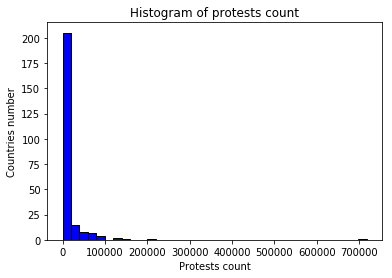

In [24]:
#changing the column name to keep the same naming convention in each dataframe
protests_df=protests_df.rename(index=str, columns={"ISO3": "Country Code"})

#counting the number of protests we have in each country
number_of_protests_per_country = protests_df.groupby(['Country Code']).size().reset_index(name='protests count')

#Getting the distribution of protests count
plt.hist(number_of_protests_per_country['protests count'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# Add labels
plt.title('Histogram of protests count')
plt.xlabel('Protests count')
plt.ylabel('Countries number')


The distribution show that few countries have a very high number of protests. These countries, with a very high number, hids the nuance between other countries.

For instance, if a country A has 1 protests, a country B has 5000 protests and country C has 100 000 protests, we won't see any difference between country A and B in the visualization. A threshold resolves this issue.

To resolve this issue we thought about two different solutions:
- adding a threshold: but we loose nuance between countries with higher number of protests
- doing a log scale

##### Threshold:

Text(0, 0.5, 'Countries number')

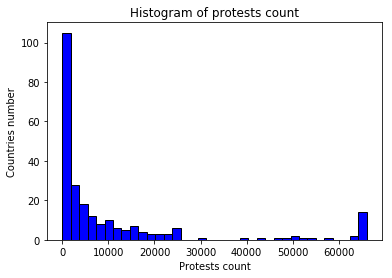

In [25]:
threshold = np.percentile(number_of_protests_per_country['protests count'], 95)
number_of_protests_per_country_thresh = number_of_protests_per_country.copy()
number_of_protests_per_country_thresh[number_of_protests_per_country_thresh['protests count'] > threshold] = threshold

#Getting the new distribution of protests count after the threshold
plt.hist(number_of_protests_per_country_thresh['protests count'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# Add labels
plt.title('Histogram of protests count')
plt.xlabel('Protests count')
plt.ylabel('Countries number')

#### Log scale:

Text(0, 0.5, 'Countries number')

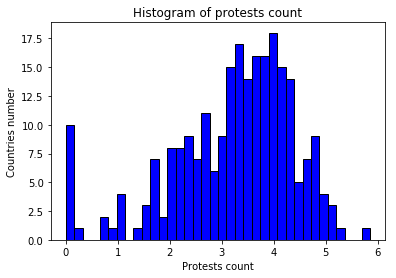

In [26]:
number_of_protests_per_country['log protests count'] = np.log10(number_of_protests_per_country['protests count'])
#Getting the distribution of logarithmic protests count
plt.hist(number_of_protests_per_country['log protests count'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# Add labels
plt.title('Histogram of protests count')
plt.xlabel('Protests count')
plt.ylabel('Countries number')

Visualizing result for log scale that allows to avoid loosing nuance between low values and between high values:

In [27]:

max_nb_protests = number_of_protests_per_country['protests count'].values.max()
colormap = linear.YlGn_09.scale(0, max_nb_protests)
colormap.caption = 'Number of protests from 2005'
swiss_loc=[46.9,8.25]
results_map_protests = folium.Map(swiss_loc, tiles='cartodbpositron', zoom_start=1) 
#creating dictionary to easily find the protest count
dictionary = number_of_protests_per_country.set_index('Country Code')['protests count']

folium.TopoJson(
    countries_topodata,
#     open('data/contries.topojson.json'),
    'objects.countries1',
    style_function=lambda x: {
        'fillColor': '#black' if (x['id'] not in dictionary.index.values) or (pd.isnull(dictionary[x['id']])) else (colormap(dictionary[x['id']])),
        'color': 'black',
        'weight': 0.5,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    },
    tooltip=folium.GeoJsonTooltip(fields=['name'],
                                  aliases=[''], 
                                  sticky=True, 
                                  style="font-family: Arial; color: black;", 
                                  opacity=0.8, 
                                  direction='top')
).add_to(results_map_protests)
results_map_protests.add_child(colormap) #adding legend to map


results_map_protests.save('results_map_protests.html')
display(HTML("<h1><a href='results_map_protests.html' target='_blank'>results_map_protests (Ctrl+Click)</a></h1>"))

results_map_protests

### Is there any correlation between number of protests and other statistics?

In [28]:
#Getting number of protests per country without any threshold
number_of_protests_per_country = protests_df.groupby(['Country Code']).size().reset_index(name='protests count')

In [29]:
#Extracting the two column we are interesting in
country_by_income_2017_filtered=country_by_income_2017[['Country Code','Income Group']]

In [30]:
#joining tables to get the country, the income group and the protests count in the same table
income_group_and_protests_count=pd.merge(country_by_income_2017_filtered, number_of_protests_per_country, how='right', on=['Country Code'])
income_group_and_protests_count.head()

,Country Code,Income Group,protests count
0,ZWE,1.0,15822
1,ZMB,3.0,2888
2,YEM,1.0,23917
3,PSE,3.0,19926
4,VIR,6.0,147


In [33]:
countries_stats_with_code=pd.merge(countries_stats, country_codes_to_name, how='left', on='Country Name')
countries_stats_with_code=countries_stats_with_code.dropna()

In [34]:
#Getting a dataframe with all the statistics by country!
countries_all_stats=pd.merge(countries_stats_with_code, income_group_and_protests_count, how='left', on='Country Code')
countries_all_stats=countries_all_stats.dropna()
#Using countries that have more than 1 protest for the linear regression
countries_all_stats=countries_all_stats[countries_all_stats['protests count'] > 1]
countries_all_stats.head()

,Country Name,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),...,Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service,Country Code,Income Group,protests count
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,...,87.65,1.0,46.60,20.34,0.380,0.240,0.380,AFG,1.0,20558.0
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,...,74.49,3.0,15.11,5.22,0.232,0.188,0.579,ALB,4.0,17846.0
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,...,96.53,1.0,17.14,4.61,0.101,0.600,0.298,DZA,4.0,8352.0
4,Argentina,LATIN AMER. & CARIB,39921833,2766890,14.4,0.18,0.61,15.18,11200.0,97.1,...,87.21,3.0,16.73,7.55,0.095,0.358,0.547,ARG,6.0,23604.0
5,Armenia,C.W. OF IND. STATES,2976372,29800,99.9,0.00,-6.47,23.28,3500.0,98.6,...,80.15,4.0,12.07,8.23,0.239,0.343,0.418,ARM,4.0,16228.0


In the dataframe above, we can access many statistics on each country such as density population, GDP (Gross Domestic Product), climate, birthrate, deathrate, infant mortality, etc. Thanks to all this available data, we can perform a linear regression to get an idea of the impact of each variable on the number of protests (stored in the dataframe too):

In [35]:
#Using linear regression to find impact of each variable on the protests count
feature_cols = ['Population', 'Area (sq. mi.)','Net migration', 'Infant mortality (per 1000 births)',
                'GDP ($ per capita)', 'Deathrate', 'Phones (per 1000)', 'Birthrate',
                'Coastline (coast/area ratio)', 'Literacy (%)']
X = countries_all_stats[feature_cols]
y = countries_all_stats['protests count']
logistic = LinearRegression()  # create the model
logistic.fit(X, y)  # train it
for f in range(len(feature_cols)):
    print("{0} * {1} + ".format(logistic.coef_[f], feature_cols[f]))
print(logistic.intercept_)

4.795971373520814e-05 * Population + 
0.01978812114881574 * Area (sq. mi.) + 
-540.8549689444078 * Net migration + 
-9.230012918070077 * Infant mortality (per 1000 births) + 
-0.4812331154297193 * GDP ($ per capita) + 
-38.65690258505301 * Deathrate + 
153.29773383198958 * Phones (per 1000) + 
986.2359317785679 * Birthrate + 
-156.93708762645966 * Coastline (coast/area ratio) + 
-138.81033559355973 * Literacy (%) + 
-28381.396064002085


In [36]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:         protests count   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     10.38
Date:                Sun, 25 Nov 2018   Prob (F-statistic):           4.57e-13
Time:                        03:56:04   Log-Likelihood:                -1892.1
No. Observations:                 155   AIC:                             3806.
Df Residuals:                     144   BIC:                             3840.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

# A list of internal milestones until Dec. 16
<u>**29/11/2018:**</u> deadline for finding new statistics on the countries (already more than 10 but it could be interesting to find other variables to evaluate.
<br><br>
<u>**31/11/2018:**</u> doing the analysis on each country but depending on the year. Finding a way to visualize the evolution of the protests numbers year per year
<br><br>
<u>**02/12/2018:**</u> finding impact of each variables on the protests number on each country based on the year As we have the number of protests per year and statistics on each country per year, we should be able to see the influence of each variable. For instance, is a country increase a lot his GDP ($ per capita) and not the other variables, and the number of protests decrease we could assume that they are related, etc (that's just a simple example).
<br><br>
<u>**05/12/2018:**</u> we though about implementing a dynamic world map that show the protests days by days in a quick way (to help you understanding what we mean, here an example of the result we would like: https://www.globalforestwatch.org/map
<br><br>
<u>**08/12/2018:**</u> we got almost all the results we wanted, we wrote good comments and explanations. The documentation is well done. We choose the way to present our work: a 4-page PDF document or a data story in a platform like a blog post.
<br><br>
<u>**14/12/2018:**</u> We got all the result we wanted. Our visualizations are good. The report or the data story through a platform is done.
<br><br>
<u>**15/12/2018:**</u> Last verifications to verify everything.